Что можно взять для того, чтобы распознавать токены как аспекты?
1. Мы говорили о CRF и подобных
2. Мы говорили о разных нейронках -- преимущественно свёртки и рекуррентные
3. Нам нужно будет работать с текстом

Исходя из этого и погуглив тьюториалы на пайторче, решено было использовать сочетание LSTM и CRF, с надеждой на то, что на наших маленьких примерах эта модель с небольшим количеством эпох не успеет сильно переобучиться

И кажется, нам удалось. Качество на тесте, конечно, ниже, чем на трейне -- однако мы выделяем почти все метки, что нужны

Что мы брали для обучения и зачем. Что -- train_split из проекта. Что мы с ним делали:
1. Взяли ревью и аспекты
2. Разметили ревью леммами, стартом и эндом (есть варианты сто станзой и с ручной разметкой, в ручной что-то сбивается)
3. По старту и энду мы нашли для каждого токена, является ли он каким-нибудь аспектом, и если да, то каким
4. Последовательность лемм предложения и последовательность тегов аспектов предложения подаётся в модель
5. С тестом делается та же предобработка
6. Последовательности лемм предложений теста подаются в модель
7. Модель отдаёт последовательность тегов аспектов
8. Каждому токену в датафрейме отдаём его аспект
9. С помощью Dostoevsky предсказываем тональность
10. На основании предсказанного собираем тональность по категориям отзыва
11. Сравниваемся с эталоном

Что получилось:
1. Моделька хорошая. Берём случайное предложение, вообще никакого отношения к корпусу не имеющее. Смотрим, как хорошо.
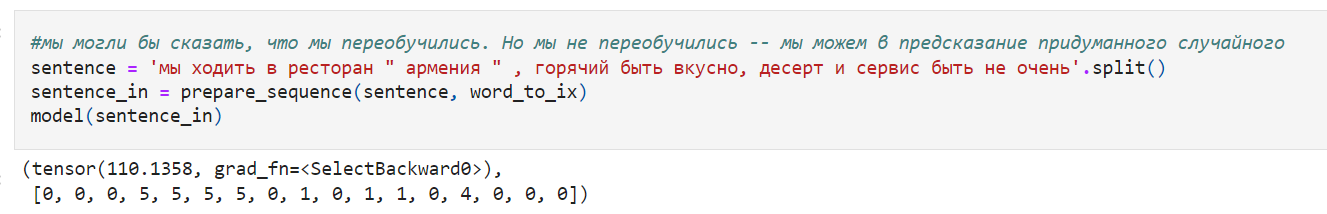

5 -- это место, 1 -- еда, 4 -- сервис. Всё как положно

2. Когда мы сравниваем наши полученные предсказания для теста с эталонными предсказаниями для теста, получается хорошо. Но это не совсем тот файл-эталон, с которым мы сравниваемся в итоге. Это метки, приписанные токенам теста точно так же, как метки трейна были приписаны токенам трейна. И вот что мы можем увидеть:
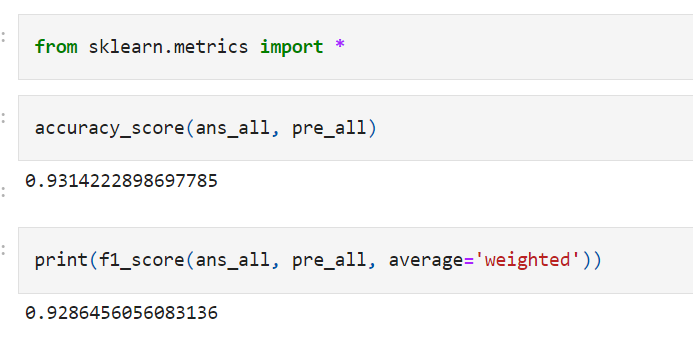

То есть вот настолько хорошо мы предсказываем метки. А теперь попробуем оценить результаты без оглядки на форма, для этого у нас есть две тетрадки: одна оценивала наши настоящие предсказания, вторая -- стандарт в нашем формате

3. Так что модель действительно хороша. Так в чём же проблема тогда? Да в предобработке. 
Вот наша:
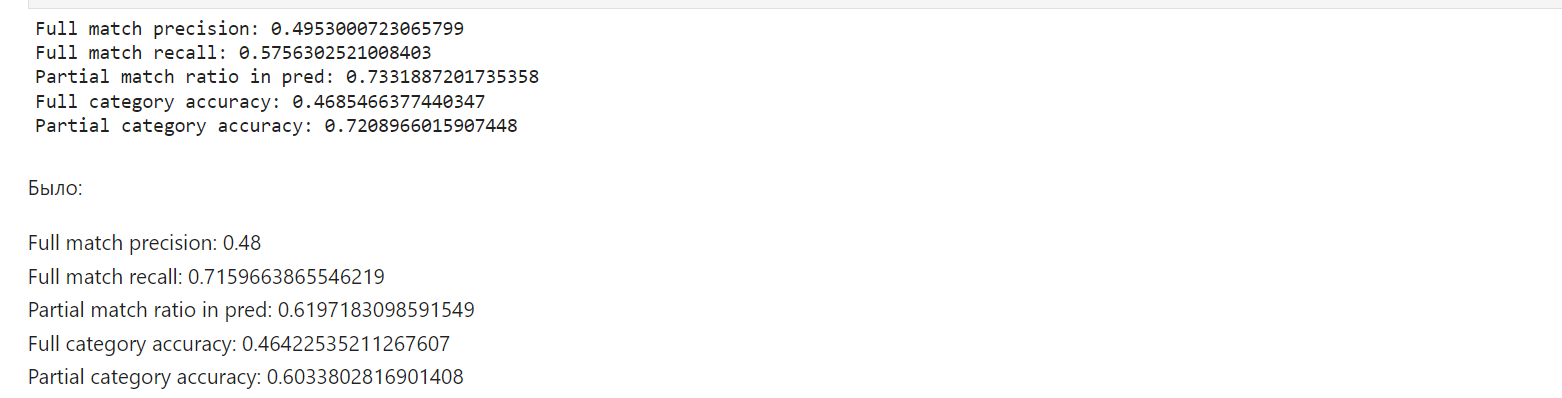

Вот стандарт:
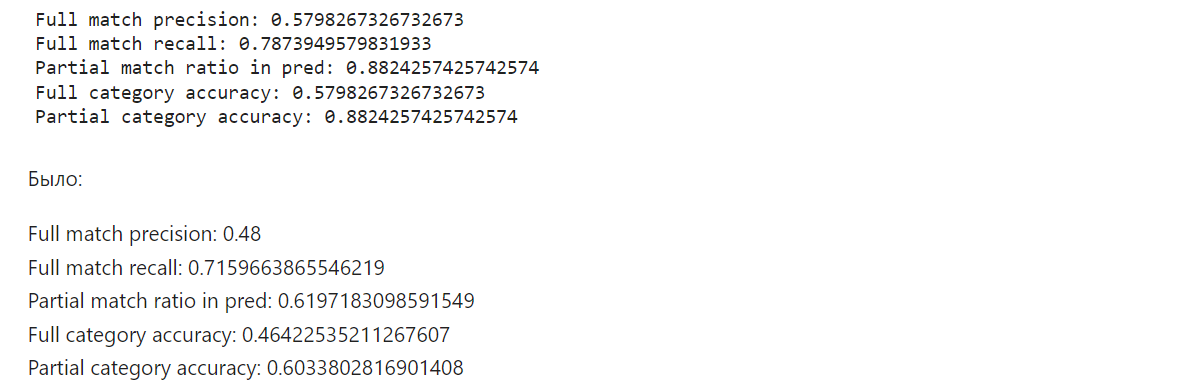

Без хорошего препроца шансов у нас не было, но давайте хотя бы приимерно посмотрим, как всё это должно быть

In [8]:
print(0.4953 * 100 / 0.579)
print(0.575 * 100 / 0.787)
print(0.733 * 100 / 0.882)
print(0.468 * 100 / 0.579)
print(0.720 * 100 / 0.882)

85.54404145077721
73.06226175349427
83.10657596371881
80.82901554404147
81.63265306122449


То есть предсказываем мы неплохо. Но разница данных делает своё дело. То же и дальше

4. Эта проблема объясняет и наши полученные на тесте результаты. Не всё, что мы выделили, совпало с золотым стандартом, потому что у нас многословные аспекты представлены как цепочка однословных. Их можно объединить относительно несложной ячейкой, но я и так вторые сутки кроме полировки своей части проекта переделываю не свою часть работы, и времени мне на всё не хватило


Что получается: раньше у нас были данные, на которых был высокий реколл, но низкое всё остальное. Сейчас наоборот. Но не потому, что мы не выделяем нужные токены (см.метрику accuracy выше), а потому, что данные надо преобразовать. К отчёту постараюсь сделать и это.

Что по тональности: да аналогично. По частично совпавшим повысилось, по полностью совпавшим понизилось. Причины, по всей видимости, те же -- не совсем то выделение токенов. Ответ на вопрос, что делать -- аналогичный предыдущему. 
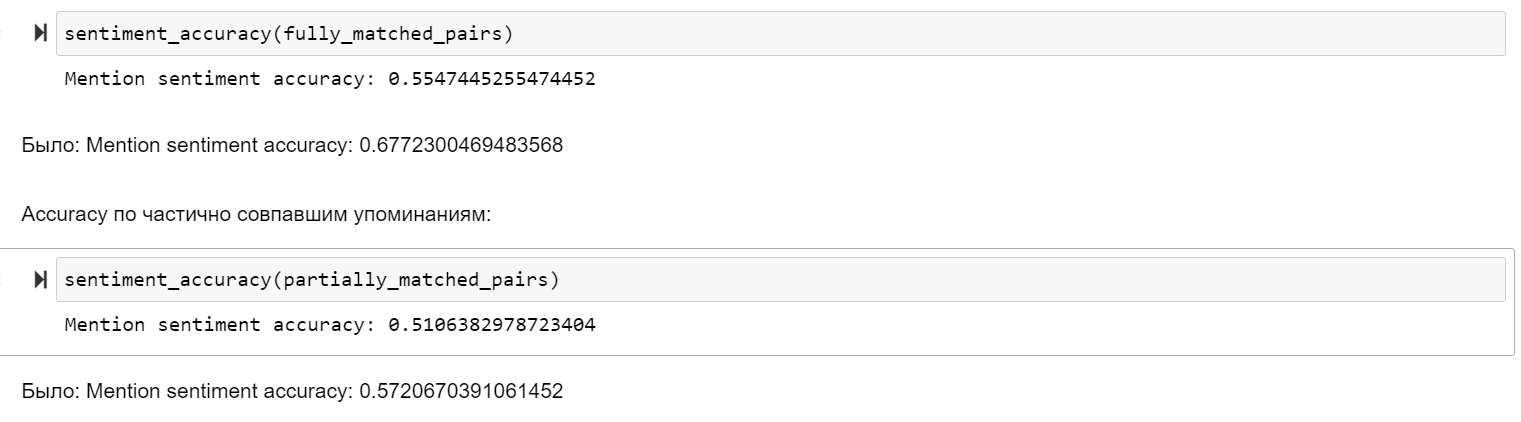

Третья часть. Почему упали метрики по этому пункту, он же не завязан на токены? На самом деле завязан. Усреднение не тех, многословные не считаются за один -- хуже результат. Ответ аналгичный.
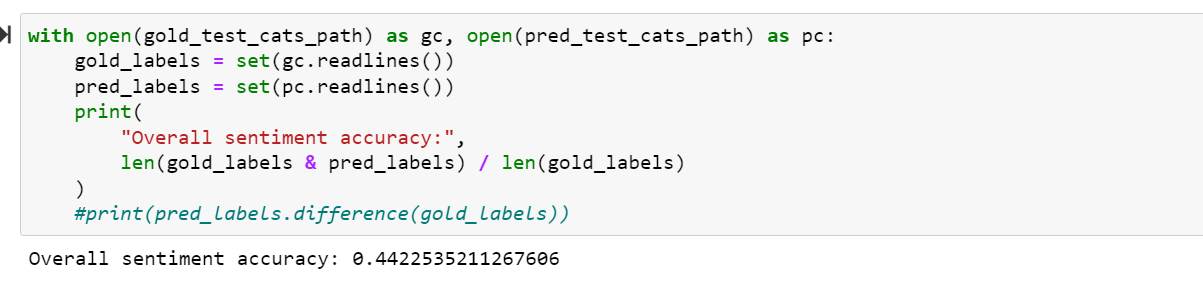

Итог. У нас подобраны хорошие в целом решения для аспектов и тональности, но так себе препроц рушит это дело. Точнее, даже не препроц, а сопоставление токенов и аспектов. Постараюсь дописать объединяющее к сдаче